# Sentiment Analysis on Product Reviews

The goal of this project is to analyze product reviews and classify them into positive or negative sentiments using ML models

#  Data Analysis Project

##  Steps
1. Import the libraries  
2. Load the dataset  
3. Explore the data (EDA)  
4. Data cleaning  
5. Data visualization  
6. Feature engineering  
7. Build a model  
8. Evaluate results  
9. Conclusion


# Step 1: Import Libraries


In [ ]:
!pip install -q -U scikit-learn nltk matplotlib WordCloud

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from google.colab import drive

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 2: Load Dataset


In [ ]:
# 3: mount Drive and set paths
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/amazon-review-dataset/"

train_file = os.path.join(data_path, "train.ft.txt")
test_file  = os.path.join(data_path, "test.ft.txt")

'# Load train file\nwith open(data_path + "train.ft.txt", "r", encoding="utf-8") as f:\n    train_data = f.readlines()\n\n# load test file\nwith open(data_path + "test.ft.txt", "r", encoding="utf-8") as f:\n    test_data = f.readlines()\n\nprint("Number of samples in Train:", len(train_data))\nprint("Number of samples in Test:", len(test_data))\n\n# Show first 3 lines as examples\nfor line in train_data[:3]:\n    print(line)'

# Step 3: Explore the Data (EDA)


In [ ]:
'''# Load train file
with open(data_path + "train.ft.txt", "r", encoding="utf-8") as f:
    train_data = f.readlines()

# load test file
with open(data_path + "test.ft.txt", "r", encoding="utf-8") as f:
    test_data = f.readlines()

print("Number of samples in Train:", len(train_data))
print("Number of samples in Test:", len(test_data))

# Show first 3 lines as examples
for line in train_data[:3]:
    print(line)'''

In [ ]:
# 4: helper function to load lines
def load_lines(path, max_lines=None):
    lines = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        if max_lines is None:
            lines = f.readlines()
        else:
            for i, line in enumerate(f):
                lines.append(line)
                if i+1 >= max_lines:
                    break
    return lines
#config: set SAMPLE_SIZE to limit memory/time.
SAMPLE_SIZE = 100000  #100000 or None.

print("Loading data (may take some time)...")
train_lines = load_lines(train_file, max_lines=SAMPLE_SIZE)
test_lines= load_lines(test_file, max_lines=int(SAMPLE_SIZE*0.1) if SAMPLE_SIZE else None)

print("Loaded train lines:", len(train_lines))
print("Loaded test  lines:", len(test_lines))

#  Step 4: Data Cleaning

In [ ]:
#5: parse label + text into DataFrame
def parse_label_text(lines):
    texts =[]
    labels=[]
    for line in lines:
        line=line.strip()
        if not line:
           continue
        parse=line.split(" ",1)   # split into [label, text]
        if len(parse)<2:
           continue
        label_str,text=parse[0],parse[1]

        lbl=label_str.replace("__label__","")
        # Map: '__label__1' -> 0 (negative), '__label__2' -> 1 (positive)
        try:
            lbl_num=int(lbl)
            # map __label__1 -> 0 (negative), __label__2 -> 1 (positive)
            labels.append(0 if lbl_num == 1 else 1)
        except:
            labels.append(0)
        texts.append(text)
    return pd.DataFrame({"text": texts, "label": labels})
train_df=parse_label_text(train_lines)
test_df=parse_label_text(test_lines)

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)
display(train_df.head())


Train shape: (100000, 2)
Test  shape: (10000, 2)


,text,label
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [ ]:
#6: cleaning / preprocessing
def clean_text(s):
    s=s.lower()
    s=re.sub(r'<[^>]+>', ' ', s)              # remove html
    s=re.sub(r'http\S+|www.\S+',' ',s)        #remove URLs
    s=re.sub(r'[^a-z0-9\s]',' ',s)            # keep alphanum + spaces
    s=re.sub(r'\s+',' ',s).strip()
    return s

def remove_stopwords(text, stopwords_set=STOPWORDS):
  tokens=text.split()
  tokens=[t for t in tokens if t not in stopwords_set]
  return " ".join(tokens)

   #apply cleaning
print ("Cleaning texts (this may take a little)...")
train_df['clean'] = train_df['text'].map(clean_text)
test_df['clean']  = test_df['text'].map(clean_text)

#remove stopwords (uncomment if desired)
REMOVE_STOPWORDS= True
if REMOVE_STOPWORDS:
    train_df['clean'] = train_df['clean'].map(lambda x: remove_stopwords(x))
    test_df['clean']  = test_df['clean'].map(lambda x: remove_stopwords(x))

display(train_df[['text','clean','label']].head())


Cleaning texts (this may take a little)...


,text,clean,label
0,Stuning even for the non-gamer: This sound tra...,stuning even non gamer sound track beautiful p...,1
1,The best soundtrack ever to anything.: I'm rea...,best soundtrack ever anything reading lot revi...,1
2,Amazing!: This soundtrack is my favorite music...,amazing soundtrack favorite music time hands i...,1
3,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack truly like soundtrack enj...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",remember pull jaw floor hearing played game kn...,1


# Step 5: Train/Test Split


In [ ]:
#7: split train -> train/val (for tuning)
X=train_df['clean']
y=train_df['label'].astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

X_test = test_df['clean']
y_test = test_df['label'].astype(int)

print("Shapes -> X_train:", X_train.shape, "X_val:", X_val.shape,  "X_test:", X_test.shape)

Shapes -> X_train: (90000,) X_val: (10000,) X_test: (10000,)


# Step 6: Vectorization


In [ ]:
#8: vectorize:countvectorizer and TF-IDF (both to comparison)
count_vect = CountVectorizer(max_features=50000,ngram_range=(1,2))
tfidf_vect = TfidfVectorizer(max_features=50000,ngram_range=(1,2))

print("fitting countvectorizer...")
X_train_count = count_vect.fit_transform(X_train)
X_val_count   = count_vect.transform(X_val)
X_test_count  = count_vect.transform(X_test)

print ("fitting TF-IDF Vectorizer...")
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_val_tfidf   = tfidf_vect.transform(X_val)
X_test_tfidf  = tfidf_vect.transform(X_test)


fitting countvectorizer...
fitting TF-IDF Vectorizer...


# Step 7: Build Models & Evaluation


In [ ]:
#9:train & evaluation function
def train_and_eval(model, X_tr, y_tr, X_v, y_v, X_test=None, y_test=None):
  model.fit(X_tr, y_tr)
  preds_val= model.predict(X_v)
  acc=accuracy_score(y_v, preds_val)
  prec, rec, f1, _ = precision_recall_fscore_support(y_v, preds_val, average='binary', zero_division=0)
  print(f"Validation -> Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
  print("Confusion matrix (val):")
  print(confusion_matrix(y_v, preds_val))
  if X_test is not None and y_test is not None:
    preds_test = model.predict(X_test)
    print("Test classification report:")
    print(classification_report(y_test, preds_test, digits=4))
  return acc, prec, rec, f1



# Step 8: Results Comparison


In [ ]:
#10: train models and collect results

results = {}

print("\n--- Logistic Regression on TF-IDF ---")
lr_tfidf_model= LogisticRegression(max_iter=400, solver='saga')  # saga handles l1/l2 & sparse well
acc, prec, rec, f1 = train_and_eval(lr_tfidf_model, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test)
results['LogReg_TFIDF'] = {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1}

print("\n--- MultinomialNB on TF-IDF ---")
nb_tfidf_model = MultinomialNB()
acc, prec, rec, f1 = train_and_eval(nb_tfidf_model, X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test)
results['NaiveBayes_TFIDF'] = {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1}

print("\n--- Logistic Regression on Count Vectors ---")
lr_count_model = LogisticRegression(max_iter=400, solver='saga')
acc, prec, rec, f1 = train_and_eval(lr_count_model, X_train_count, y_train, X_val_count, y_val, X_test_count, y_test)
results['LogReg_Count'] = {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1}

print("\n--- MultinomialNB on Count Vectors ---")
nb_count_model = MultinomialNB()
acc, prec, rec, f1 = train_and_eval(nb_count_model, X_train_count, y_train, X_val_count, y_val, X_test_count, y_test)
results['NaiveBayes_Count'] = {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1}



--- Logistic Regression on TF-IDF ---
Validation -> Accuracy: 0.8966  Precision: 0.8914  Recall: 0.9091  F1: 0.9002
Confusion matrix (val):
[[4305  568]
 [ 466 4661]]
Test classification report:
              precision    recall  f1-score   support

           0     0.9024    0.8802    0.8912      4875
           1     0.8887    0.9095    0.8989      5125

    accuracy                         0.8952     10000
   macro avg     0.8955    0.8948    0.8951     10000
weighted avg     0.8954    0.8952    0.8952     10000


--- MultinomialNB on TF-IDF ---
Validation -> Accuracy: 0.8761  Precision: 0.8753  Recall: 0.8843  F1: 0.8798
Confusion matrix (val):
[[4227  646]
 [ 593 4534]]
Test classification report:
              precision    recall  f1-score   support

           0     0.8763    0.8544    0.8652      4875
           1     0.8647    0.8853    0.8749      5125

    accuracy                         0.8702     10000
   macro avg     0.8705    0.8698    0.8700     10000
weighted avg   

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression with Count Vectorizer achieved the highest F1-score, so we consider it the best performing model


=== Model Comparison ===


,acc,prec,rec,f1
LogReg_TFIDF,0.8966,0.891375,0.909109,0.900154
NaiveBayes_TFIDF,0.8761,0.875290,0.884338,0.879790
LogReg_Count,0.8967,0.893502,0.906573,0.899990
NaiveBayes_Count,0.8748,0.878788,0.876731,0.877758


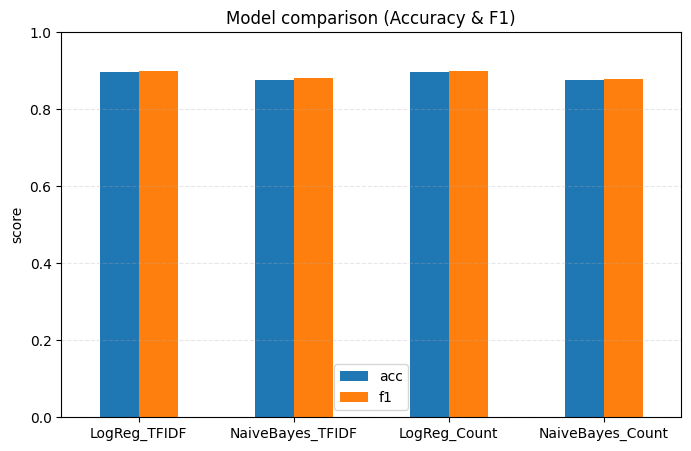

In [ ]:
#11: comparison table + bar chart ======
res_df = pd.DataFrame(results).T[['acc','prec','rec','f1']]
print("\n=== Model Comparison ===")
display(res_df)

# plot Accuracy and F1 for quick view
res_df[['acc','f1']].plot(kind='bar', figsize=(8,5))
plt.title("Model comparison (Accuracy & F1)")
plt.ylim(0,1)
plt.ylabel("score")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

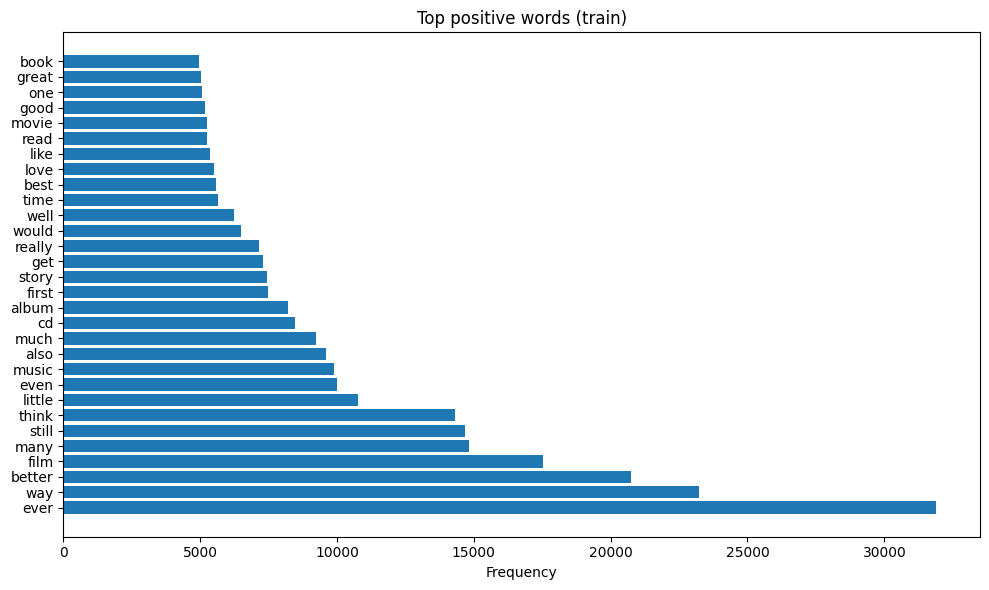

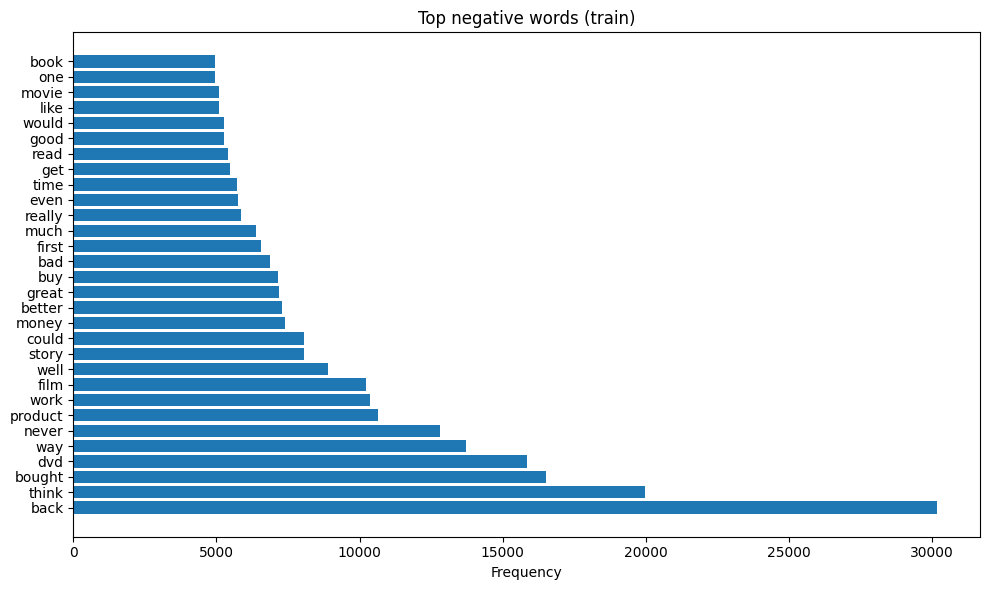

In [ ]:
#12: top words + wordclouds
def top_n_words(corpus, n=30):
    counter = Counter()
    for doc in corpus:
        counter.update(doc.split())
    return counter.most_common(n)

pos_texts = train_df[train_df['label'] == 1]['clean']
neg_texts = train_df[train_df['label'] == 0]['clean']

top_pos = top_n_words(pos_texts, 30)
top_neg = top_n_words(neg_texts, 30)

def plot_top_words(top_words, title):
    words, counts = zip(*top_words)
    plt.figure(figsize=(10,6))
    plt.barh(range(len(words))[::-1], counts[::-1])
    plt.yticks(range(len(words)), words[::-1])
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_top_words(top_pos, "Top positive words (train)")
plot_top_words(top_neg, "Top negative words (train)")


# Step 9: Save Models


In [ ]:
#13: save best models & vectorizers ======
import joblib
out_dir = os.path.join("/content/drive/MyDrive/models/amazon_sentiment")
os.makedirs(out_dir, exist_ok=True)

joblib.dump(lr_tfidf_model, os.path.join(out_dir, "logreg_tfidf.joblib"))
joblib.dump(nb_tfidf_model, os.path.join(out_dir, "nb_tfidf.joblib"))
joblib.dump(lr_count_model, os.path.join(out_dir, "logreg_count.joblib"))
joblib.dump(nb_count_model, os.path.join(out_dir, "nb_count.joblib"))

joblib.dump(tfidf_vect, os.path.join(out_dir, "tfidf_vectorizer.joblib"))
joblib.dump(count_vect, os.path.join(out_dir, "count_vectorizer.joblib"))

print("Saved models and vectorizers to", out_dir)

Saved models and vectorizers to /content/drive/MyDrive/models/amazon_sentiment
